In [44]:
%matplotlib inline

import torch

import matplotlib.pyplot as plt
from PIL import Image
from dataset import Caltech256
from methods import L2PGD
from methods import v11, r18, v16, vb11, r50
from torchvision import transforms as T
from torch.utils.data import DataLoader
from torchvision import models
import numpy as np
from methods import load_model

In [7]:
plt.rcParams['figure.dpi'] = 100

device = torch.device('cuda:0')

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
TEST_TRANSFORMS = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])
SPLIT="train"

test = Caltech256("/data/Datasets/Caltech-256", train=False, transform=TEST_TRANSFORMS)
i2c = lambda index: test.idx_to_class[index]
train = Caltech256("/data/Datasets/Caltech-256", train=True, transform=TEST_TRANSFORMS)



def load_data(idx):
    if SPLIT == 'train':
        image, target = train.__getitem__(idx)
    else:
        image, target = test.__getitem__(idx)
    return image

def getimage(path):
    i = Image.open(path)
    i = TEST_TRANSFORMS(i)
    return i

def load_prev_model(name):
    if name.find('resnet18') != -1:
        model = r18(257, MEAN, STD)
    elif name.find('vgg11') != -1:
        model = v11(257, MEAN, STD)
    elif name.find('vgg16') != -1:
        model = v16(257, MEAN, STD)
    model.load_state_dict(torch.load(name, map_location=device))
    model = model.to(device)
    model.eval()
    return model

def show_tensor(t):
    img = t.permute(1, 2, 0).detach().cpu().numpy()
    # print(img.shape)
    plt.imshow(img)
    
def classify(image, model, k=5):
    data = image.unsqueeze(0).to(device)
    prob = model.classify(data)
    probs, indices = torch.topk(prob[0], k)
    for i in range(k):
        print("{0:3}, {1:20}, {2:.4f}".format(indices[i], i2c(indices[i].item()), probs[i]))
    
#classifier = load_model("v11-m1-r1.pth", 257, MEAN, STD, device)
r50_pretrain = load_model("r50-pretrained.pth", 257, MEAN, STD, device)
r50_init = r50(257, MEAN, STD).to(device)

In [40]:
print(test.classes)
print(test.idx_to_class)
print(test.class_to_idx)

['doorknob', 't-shirt', 'lathe', 'mandolin', 'harp', 'ibis-101', 'mattress', 'pez-dispenser', 'steering-wheel', 'motorbikes-101', 'bonsai-101', 'fire-hydrant', 'refrigerator', 'clutter', 'harpsichord', 'grand-piano-101', 'tricycle', 'rifle', 'goldfish', 'american-flag', 'binoculars', 'teddy-bear', 'unicorn', 'dolphin-101', 'ice-cream-cone', 'butterfly', 'welding-mask', 'stained-glass', 'gas-pump', 'dice', 'camel', 'frisbee', 'skyscraper', 'sheet-music', 'screwdriver', 'computer-keyboard', 'tombstone', 'breadmaker', 'school-bus', 'tennis-ball', 'revolver-101', 'coffee-mug', 'iguana', 'telephone-box', 'conch', 'license-plate', 'zebra', 'eyeglasses', 'picnic-table', 'chopsticks', 'mountain-bike', 'stirrups', 'eiffel-tower', 'mussels', 'waterfall', 'sword', 'fried-egg', 'snake', 'paper-shredder', 'windmill', 'tennis-court', 'dog', 'scorpion-101', 'frog', 'tomato', 'birdbath', 'boom-box', 'people', 'cactus', 'fireworks', 'golf-ball', 'goat', 'jesus-christ', 'snail', 'knife', 'electric-guita

In [41]:
print(test.img_paths[:10])

['/data/Datasets/Caltech-256/Caltech-256/test/058.doorknob/058_0073.jpg', '/data/Datasets/Caltech-256/Caltech-256/test/058.doorknob/058_0023.jpg', '/data/Datasets/Caltech-256/Caltech-256/test/058.doorknob/058_0041.jpg', '/data/Datasets/Caltech-256/Caltech-256/test/058.doorknob/058_0032.jpg', '/data/Datasets/Caltech-256/Caltech-256/test/058.doorknob/058_0005.jpg', '/data/Datasets/Caltech-256/Caltech-256/test/058.doorknob/058_0016.jpg', '/data/Datasets/Caltech-256/Caltech-256/test/058.doorknob/058_0090.jpg', '/data/Datasets/Caltech-256/Caltech-256/test/058.doorknob/058_0038.jpg', '/data/Datasets/Caltech-256/Caltech-256/test/058.doorknob/058_0019.jpg', '/data/Datasets/Caltech-256/Caltech-256/test/058.doorknob/058_0088.jpg']


In [45]:
train_dataset = Caltech256("/data/Datasets/Caltech-256", train=False, transform=TEST_TRANSFORMS, inversion=True)

In [46]:
train_loader = DataLoader(train_dataset, batch_size=4, num_workers=12, pin_memory=False)
train_data, train_lable, dir_name, file_name = next(iter(train_loader))
print(dir_name)
print(file_name) 

('058.doorknob', '058.doorknob', '058.doorknob', '058.doorknob')
('058_0073.jpg', '058_0023.jpg', '058_0041.jpg', '058_0032.jpg')


In [47]:
print(dir_name[0])

058.doorknob


In [22]:
def show_tensors(t):
    bs = t.shape[0]
    for i in range(bs):
        img = t[i].permute(1, 2, 0).detach().cpu().numpy()
        plt.subplot(1, bs, i + 1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.show()

train_loader = DataLoader(train, batch_size=4, num_workers=12, pin_memory=False)
train_data, train_lable = next(iter(train_loader))
print(train_data.shape)

torch.Size([4, 3, 224, 224])


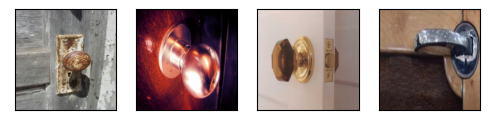

In [23]:
show_tensors(train_data)

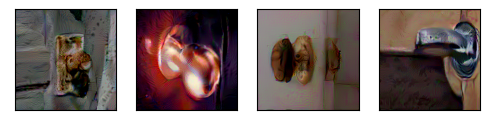

In [38]:
show_tensors(r)

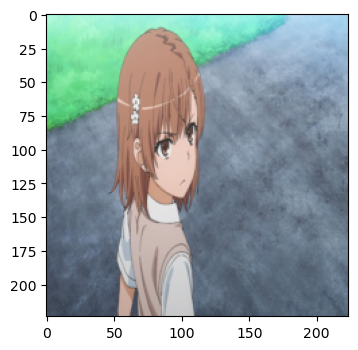

In [8]:
img = getimage('1.jpg')
show_tensor(img)

In [9]:
print(len(train))

24581


In [10]:
data = load_data(200).clone().unsqueeze(0).to(device)
with torch.no_grad():
    fm = r50_pretrain.fm(data, 19)
print(fm.shape)

fm = fm.view(2048, -1)
print(fm.shape)

p = torch.pca_lowrank(fm, 49)
U, S, V = p
print(U.shape)
print(S.shape)
print(V.shape)

fm = fm.detach().cpu().numpy()
print(fm.shape)

from sklearn.decomposition import PCA

pca = PCA(n_components=30)
pca.fit(fm)
print(pca.explained_variance_ratio_.sum())

composed = pca.transform(fm)
print(composed.shape)

fm_recon = pca.inverse_transform(composed)
print(fm_recon.shape)

print(pca.get_params())

torch.Size([1, 2048, 7, 7])
torch.Size([2048, 49])
torch.Size([2048, 49])
torch.Size([49])
torch.Size([49, 49])
(2048, 49)
0.94272393
(2048, 30)
(2048, 49)
{'copy': True, 'iterated_power': 'auto', 'n_components': 30, 'random_state': None, 'svd_solver': 'auto', 'tol': 0.0, 'whiten': False}


Ori Criterion 1.0443
Criterion 0.2203


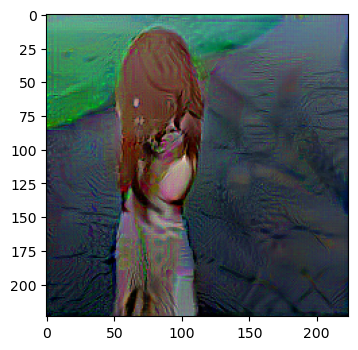

In [33]:
def rebuild_image_fm(image, model, layer_idx):
    with torch.no_grad():
        if len(image.shape) == 3:
            ori_fm1 = model.fm(image.unsqueeze(0).to(device), 19)
        else:
            ori_fm1 = model.fm(image.to(device), 19)
        # ori_fm1[0, :1024] = 0.
    
    def criterion(x, y):
        rnd_fm = model.fm(x, layer_idx)
        return torch.div(torch.norm(rnd_fm-ori_fm1, dim=1), torch.norm(ori_fm1, dim=1)).mean()\
    
    attacker = L2PGD(model=model, epsilon=1000, step=1e-3, iterations=1000, criterion=criterion, random_start=False, targeted=True)
    # attacker = L2PGD(model=model, epsilon=10000, step=1e-3, iterations=10000, criterion=criterion, random_start=False, targeted=True)
    # rand_x = image.unsqueeze(0).to(device) + (torch.rand_like(image.unsqueeze(0)).to(device)-0.5) * 2
    if len(image.shape) == 3:
        rand_x = torch.ones_like(image.unsqueeze(0)).to(device) * 0.125
    else:
        rand_x = torch.ones_like(image).to(device) * 0.125
    
    
    
    with torch.no_grad():
        print("Ori Criterion {:.4f}".format(criterion(rand_x, torch.tensor([0])).item()))
    
    res = attacker.attack(rand_x, torch.tensor([0]).to(device))
    
    
#     for i in range(500):
#         rand_x.requires_grad = True
#         loss = criterion(rand_x, 0)
#         model.zero_grad()
#         loss.backward()
#         rand_x.requires_grad = False
        
#         grad = rand_x.grad
#         rand_x = rand_x - grad / grad.norm(2)
        
#     res = rand_x.clone()
    
    
    with torch.no_grad():
        print("Criterion {:.4f}".format(criterion(res, torch.tensor([0])).item()))
    
    return res

def rebuild_image_fv(image, model, layer_idx):
    with torch.no_grad():
        ori_fm = model.fm(image.unsqueeze(0).to(device), 19)
        ori_fv = model.bone.avgpool(ori_fm)
    
    def criterion(x, y):
        rnd_fm = model.fm(x, layer_idx)
        rnd_fv = model.bone.avgpool(rnd_fm)
        return torch.div(torch.norm(rnd_fv-ori_fv, dim=1), torch.norm(ori_fv, dim=1)).mean()\
    
    attacker = L2PGD(model=model, epsilon=1000, step=1e-3, iterations=2000, criterion=criterion, random_start=False, targeted=True)
    rand_x = torch.rand_like(image.unsqueeze(0)).to(device)
    res = attacker.attack(rand_x, torch.tensor([0]).to(device))
    
    with torch.no_grad():
        print("Criterion {:.4f}".format(criterion(rand_x, torch.tensor([0])).item()))
    
    return res[0]

r = rebuild_image_fm(img, r50_pretrain, 19)
show_tensor(r[0])

In [34]:
r = rebuild_image_fm(train_data, r50_pretrain, 19)

Ori Criterion 1.0596
Criterion 0.1438


In [36]:
print(r.shape)

torch.Size([4, 3, 224, 224])


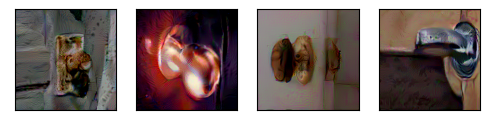

In [37]:
show_tensors(r)

In [7]:
classify(r, classifier)

 88, goose               , 0.7100
235, unicorn             , 0.1320
 12, birdbath            , 0.0942
 59, duck                , 0.0392
206, swan                , 0.0141


In [7]:
data = img.clone().unsqueeze(0).to(device)
with torch.no_grad():
    fm = r50_pretrain.fm(data, 19)
print(fm.shape)

fm = fm.view(2048, -1)
print(fm.shape)

std = torch.std(fm, dim=1)
print(torch.topk(std, 2048))

torch.Size([1, 2048, 7, 7])
torch.Size([2048, 49])
torch.return_types.topk(
values=tensor([0.6147, 0.4304, 0.3944,  ..., 0.0000, 0.0000, 0.0000], device='cuda:0'),
indices=tensor([ 739, 1088,  850,  ...,  928, 1236, 1264], device='cuda:0'))


Ori Criterion 1.0443
Criterion 0.1894


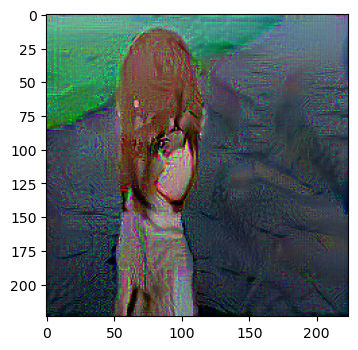

In [12]:
r = rebuild_image_fm(getimage("1.jpg"), r50_pretrain, 19)
show_tensor(r)

Criterion 1.3471


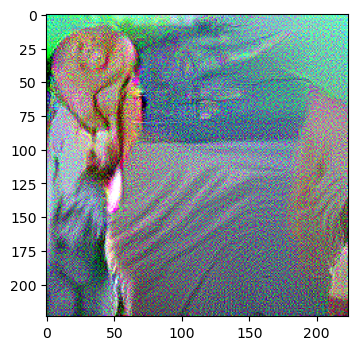

In [10]:
r = rebuild_image_fv(getimage("1.jpg"), r50_pretrain, 19)
show_tensor(r)

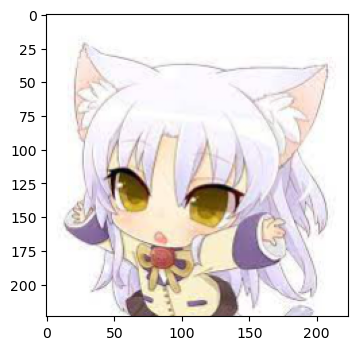

In [6]:
show_tensor(getimage("1.JPEG"))

Ori Criterion 1.1371
Criterion 0.1374


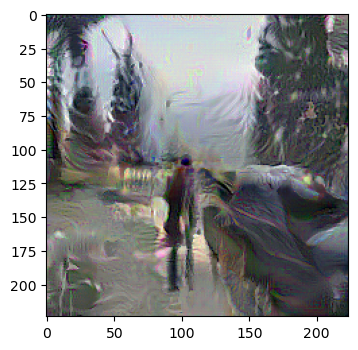

In [89]:
r = rebuild_image_fm(getimage("2.JPEG"), r50_pretrain, 19)
show_tensor(r)

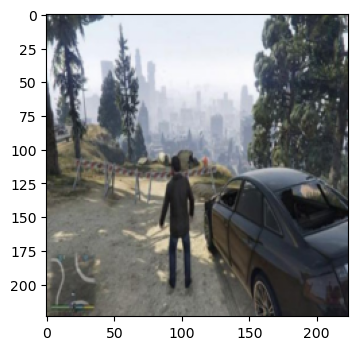

In [16]:
show_tensor(getimage("2.JPEG"))

Ori Criterion 1.0417
Criterion 0.0415


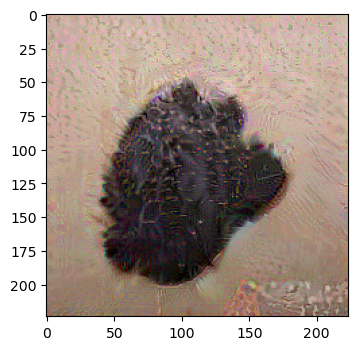

In [90]:
r = rebuild_image_fm(getimage("3.JPEG"), r50_pretrain, 19)
show_tensor(r)

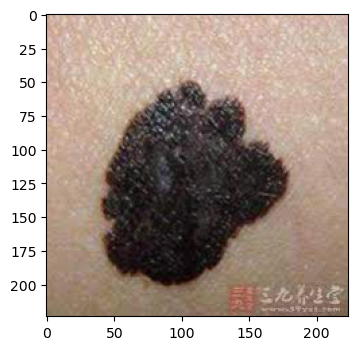

In [17]:
show_tensor(getimage("3.JPEG"))

Ori Criterion 0.8837
Criterion 0.0224


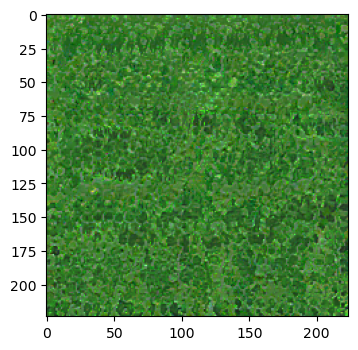

In [91]:
r = rebuild_image_fm(getimage("4.JPEG"), r50_pretrain, 19)
show_tensor(r)

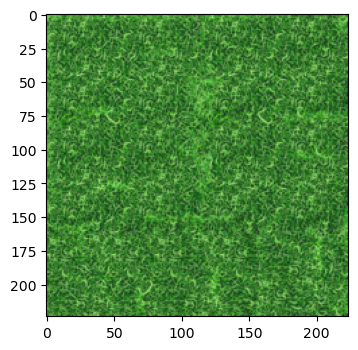

In [19]:
show_tensor(getimage("4.JPEG"))

Ori Criterion 0.9630
Criterion 0.0705


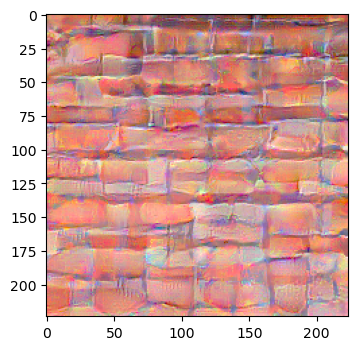

In [92]:
r = rebuild_image_fm(getimage("5.JPEG"), r50_pretrain, 19)
show_tensor(r)

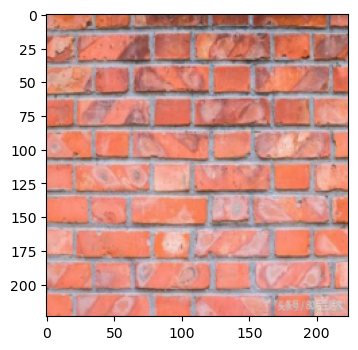

In [21]:
show_tensor(getimage("5.JPEG"))

In [46]:
from skimage.metrics import peak_signal_noise_ratio as f_psnr
from skimage.metrics import structural_similarity as f_ssim

def test(path, model):
    r = rebuild_image_fm(getimage(path), model, 19)
    # r = rebuild_image_fv(getimage(path), model, 19)
    
    ori = getimage(path)
    
    plt.axis("off")
    plt.subplot(1, 2, 1)
    plt.axis("off")
    show_tensor(r)
    plt.subplot(1, 2, 2)
    plt.axis("off")
    show_tensor(ori)
    
    maxpsnr = f_psnr(ori.permute(1, 2, 0).detach().cpu().numpy(),
                   ori.permute(1, 2, 0).detach().cpu().numpy(),
                   data_range=1.0)
    psnr = f_psnr(ori.permute(1, 2, 0).detach().cpu().numpy(),
                 r.permute(1, 2, 0).detach().cpu().numpy(),
                 data_range=1.0)
    
    print("PSNR: {:.4f} (maximum: {:.4f})".format(psnr, maxpsnr))
    
    maxssim = f_ssim(ori.permute(1, 2, 0).detach().cpu().numpy(),
                     ori.permute(1, 2, 0).detach().cpu().numpy(),
                     multichannel=True)
    
    ssim = f_ssim(ori.permute(1, 2, 0).detach().cpu().numpy(),
                  r.permute(1, 2, 0).detach().cpu().numpy(),
                  multichannel=True)
    
    print("SSIM: {:.4f} (maximum: {:.4f})".format(ssim, maxssim))
    
    
    # feature = models.vgg19(pretrained=True).features.to(device)
    feature = torch.nn.Sequential(*list(models.resnet18(pretrained=True).children())[:-2]).to(device)
    ori_f = feature(ori.clone().unsqueeze(0).to(device))
    r_f = feature(r.clone().unsqueeze(0).to(device))
    print("Feature diff: {:.4f}".format(torch.nn.functional.mse_loss(ori_f, r_f).item()))
    


Ori Criterion 0.9860
Criterion 0.1590
PSNR: 16.5435 (maximum: inf)
SSIM: 0.5241 (maximum: 1.0000)
Feature diff: 2.0006


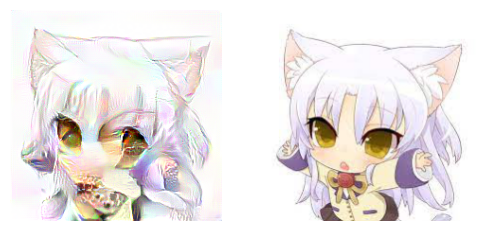

In [93]:
test("1.JPEG", r50_pretrain)

Ori Criterion 1.2687
Criterion 1.1865
PSNR: 14.0230 (maximum: inf)
SSIM: 0.2681 (maximum: 1.0000)
Feature diff: 3.0550


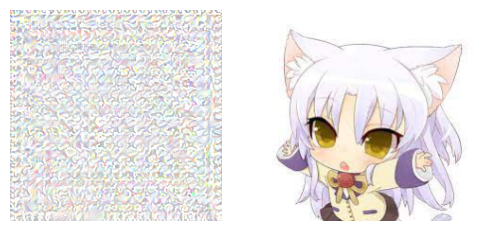

In [94]:
test("1.JPEG", r50_init)

Ori Criterion 1.1062
Criterion 0.0793
PSNR: 17.0985 (maximum: inf)
SSIM: 0.3183 (maximum: 1.0000)
Feature diff: 2.2191


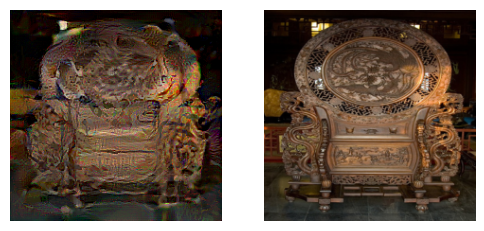

In [95]:
test("ori.JPEG", r50_pretrain)

Ori Criterion 1.2977
Criterion 1.1754
PSNR: 14.6241 (maximum: inf)
SSIM: 0.2575 (maximum: 1.0000)
Feature diff: 2.9624


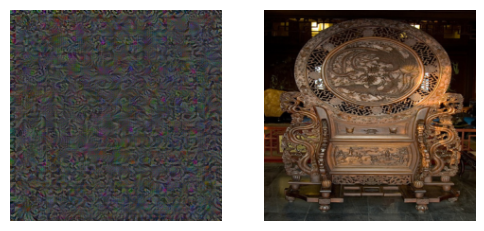

In [96]:
test("ori.JPEG", r50_init)

Ori Criterion 1.0465
Criterion 0.0989
PSNR: 17.4000 (maximum: inf)
SSIM: 0.4649 (maximum: 1.0000)
Feature diff: 1.9730


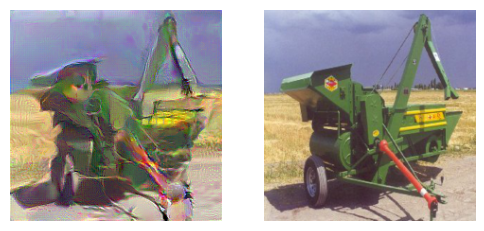

In [97]:
test("ori2.JPEG", r50_pretrain)

Ori Criterion 1.2834
Criterion 1.1687
PSNR: 13.7177 (maximum: inf)
SSIM: 0.4657 (maximum: 1.0000)
Feature diff: 2.8629


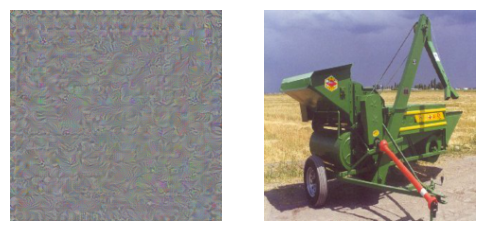

In [98]:
test("ori2.JPEG", r50_init)

Ori Criterion 1.0417
Criterion 0.0436
PSNR: 21.3158 (maximum: inf)
SSIM: 0.5007 (maximum: 1.0000)
Feature diff: 2.3487


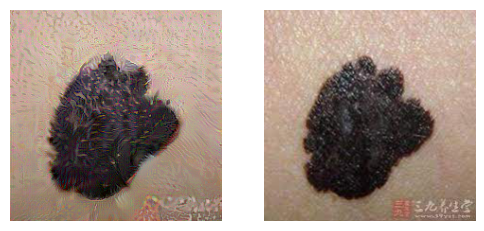

In [99]:
test("3.JPEG", r50_pretrain)

Ori Criterion 1.3118
Criterion 1.1751
PSNR: 12.2244 (maximum: inf)
SSIM: 0.5028 (maximum: 1.0000)
Feature diff: 3.0522


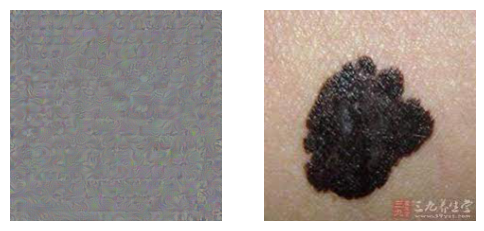

In [100]:
test("3.JPEG", r50_init)

Ori Criterion 1.0731
Criterion 0.1318
PSNR: 16.7252 (maximum: inf)
SSIM: 0.4621 (maximum: 1.0000)
Feature diff: 2.0965


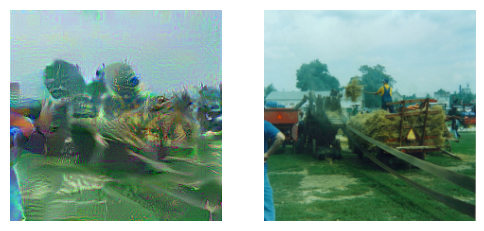

In [101]:
test("test1.JPEG", r50_pretrain)

Ori Criterion 1.2933
Criterion 1.2018
PSNR: 10.9073 (maximum: inf)
SSIM: 0.4826 (maximum: 1.0000)
Feature diff: 2.8209


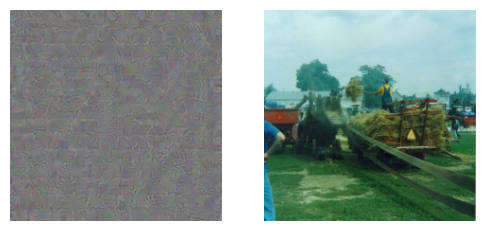

In [102]:
test("test1.JPEG", r50_init)

Ori Criterion 1.0835
Criterion 0.4146
PSNR: 4.9955 (maximum: inf)
SSIM: 0.3262 (maximum: 1.0000)
Feature diff: 2.3530


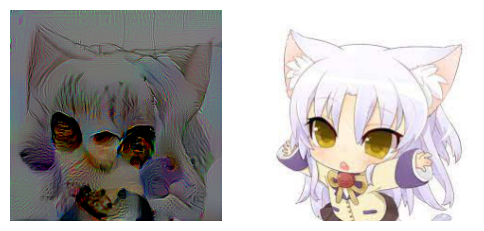

In [123]:
test("1.JPEG", r50_pretrain)

Ori Criterion 1.6901
Criterion 0.0852
PSNR: 11.9126 (maximum: inf)
SSIM: 0.1312 (maximum: 1.0000)
Feature diff: 2.3354


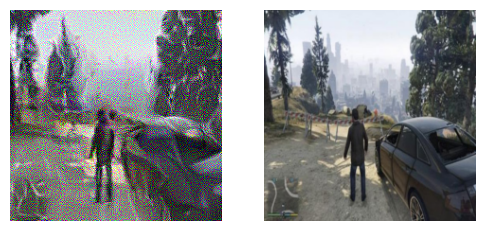

In [113]:
test("2.JPEG", r50_pretrain)

Ori Criterion 1.7282
Criterion 0.0375
PSNR: 12.3276 (maximum: inf)
SSIM: 0.0921 (maximum: 1.0000)
Feature diff: 2.3386


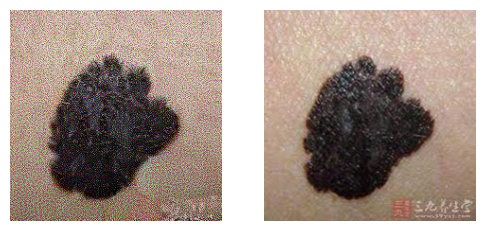

In [114]:
test("3.JPEG", r50_pretrain)

Ori Criterion 1.4989
Criterion 0.0419
PSNR: 10.8493 (maximum: inf)
SSIM: 0.0828 (maximum: 1.0000)
Feature diff: 2.7725


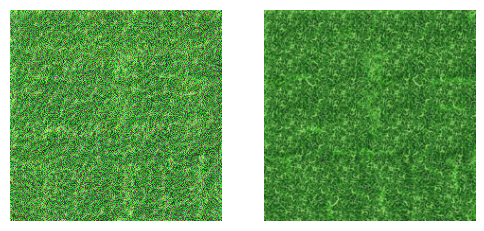

In [115]:
test("4.JPEG", r50_pretrain)

Ori Criterion 1.3181
Criterion 0.0484
PSNR: 11.0111 (maximum: inf)
SSIM: 0.1274 (maximum: 1.0000)
Feature diff: 2.7487


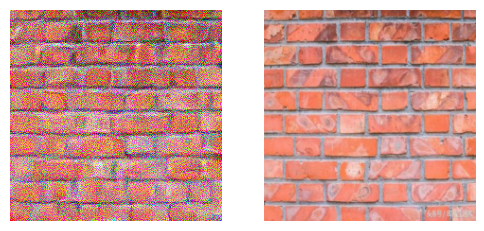

In [116]:
test("5.JPEG", r50_pretrain)

Ori Criterion 1.7617
Criterion 0.1165
PSNR: 11.0591 (maximum: inf)
SSIM: 0.1043 (maximum: 1.0000)
Feature diff: 2.3255


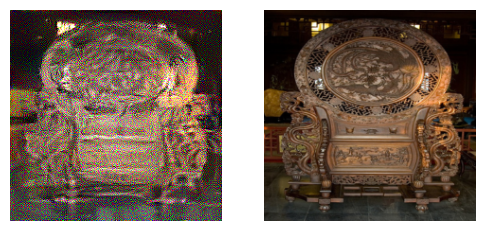

In [117]:
test("ori.JPEG", r50_pretrain)

Ori Criterion 1.4803
Criterion 0.0512
PSNR: 11.7862 (maximum: inf)
SSIM: 0.1139 (maximum: 1.0000)
Feature diff: 1.9164


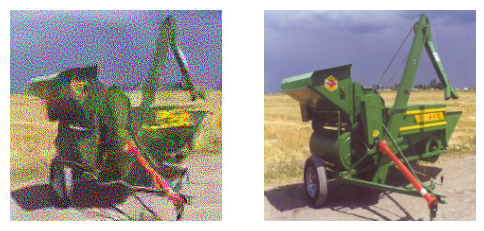

In [118]:
test("ori2.JPEG", r50_pretrain)

Ori Criterion 1.9627
Criterion 0.1108
PSNR: 11.8385 (maximum: inf)
SSIM: 0.0933 (maximum: 1.0000)
Feature diff: 2.1272


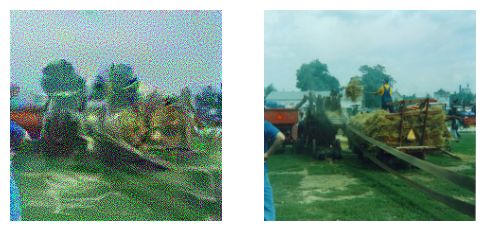

In [119]:
test("test1.JPEG", r50_pretrain)